# Boosting in Cox Regression

## Load libraries

In [1]:
## load the required packages

# clear all workspace
rm(list=ls()) 
# install the necessary packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")


Attaching package: ‘mlr3extralearners’


The following object is masked from ‘package:mlr3learners’:

    LearnerClassifNnet


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: paradox


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: parallel

Loading required package: stabs

Loading required package: survival

Loading required package: Matrix

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mboost’:

    %+%


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()     masks mboost::%+%()
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks M

## Create the task for d8

In [2]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [10]:
# get the corresponding dataframe1
train_data_d8 <- train_data_original$d8

In [11]:
## create the corresponding task as for dataframe 1
tsks_train_d8 <- TaskSurv$new("df8", backend = train_data_original$d8, time = "time", event = "status")
## check the task
tsks_train_d8

<TaskSurv:df8> (30 x 4)
* Target: time, status
* Properties: -
* Features (2):
  - int (2): V1, V2

## Hyperparameter Tuning for `d8`


#### Step 1: Boosting with the AFT model

Step 1_1: Try with a default setting

In [12]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_train_d8,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design)

INFO  [02:03:53.759] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:03:53.769] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 2/3) 
INFO  [02:03:54.020] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 3/3) 
INFO  [02:03:54.277] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 1/3) 
INFO  [02:03:54.551] [mlr3]  Finished benchmark 


In [13]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.702

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5618e5f12bf0>,df8,surv.mboost,cv,3,0.701625


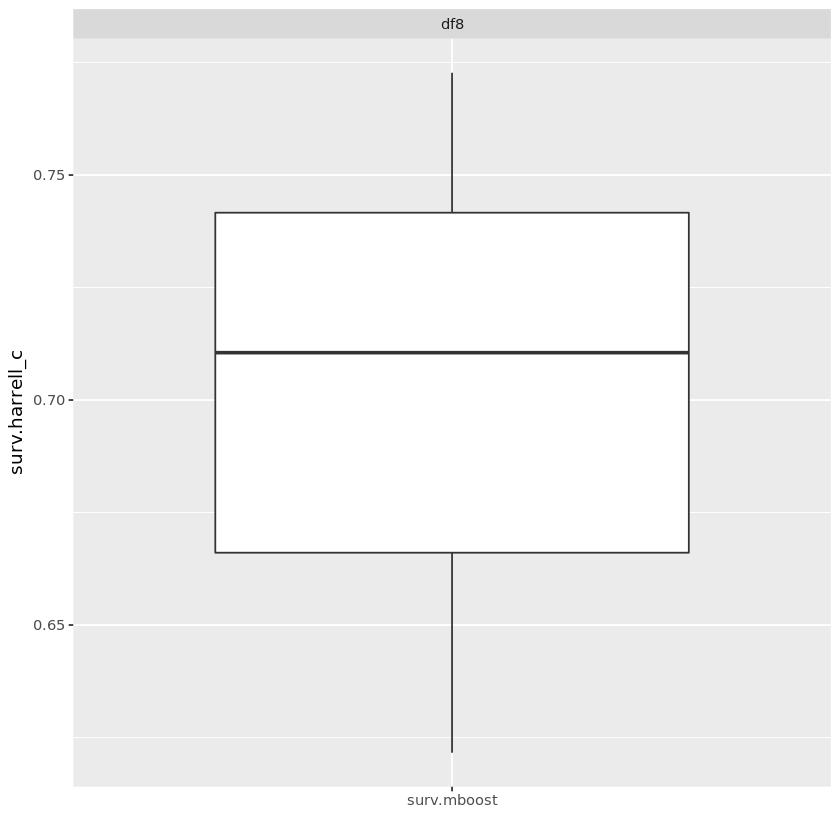

In [14]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [15]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_train_d8, grid_auto_aft, outer_rsmp, store_models = TRUE)

INFO  [02:04:22.210] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df8' (iter 2/3) 
INFO  [02:04:22.250] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [02:04:22.255] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:04:22.286] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:04:22.296] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 2/3) 
INFO  [02:04:22.827] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 3/3) 
INFO  [02:04:23.329] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 1/3) 
INFO  [02:04:23.873] [mlr3]  Finished benchmark 
INFO  [02:04:23.918] [bbotk] Result of batch 1: 
INFO  [02:04:23.921] [bbotk]  baselearner  family mstop   nu surv.harrell_c 
INFO  [02:04:23.921] [bbotk]         bols weibull   245 0.25      0.7777778 
INFO  [02:04:23.921] [bbotk]                                 uhash 
INFO  [02:04:23.921] [bbotk]  dd7e9abc-5e36-4bb1-b90f-eb8f5ef491d0 
I

Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning 

In [16]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.686

surv.harrell_c 
     0.6859826

In [17]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "lognormal"

[[1]]$baselearner
[1] "btree"

[[1]]$mstop
[1] 161

[[1]]$nu
[1] 0.5

Step 1_3: Autoplot the pre and after tuning boxplots

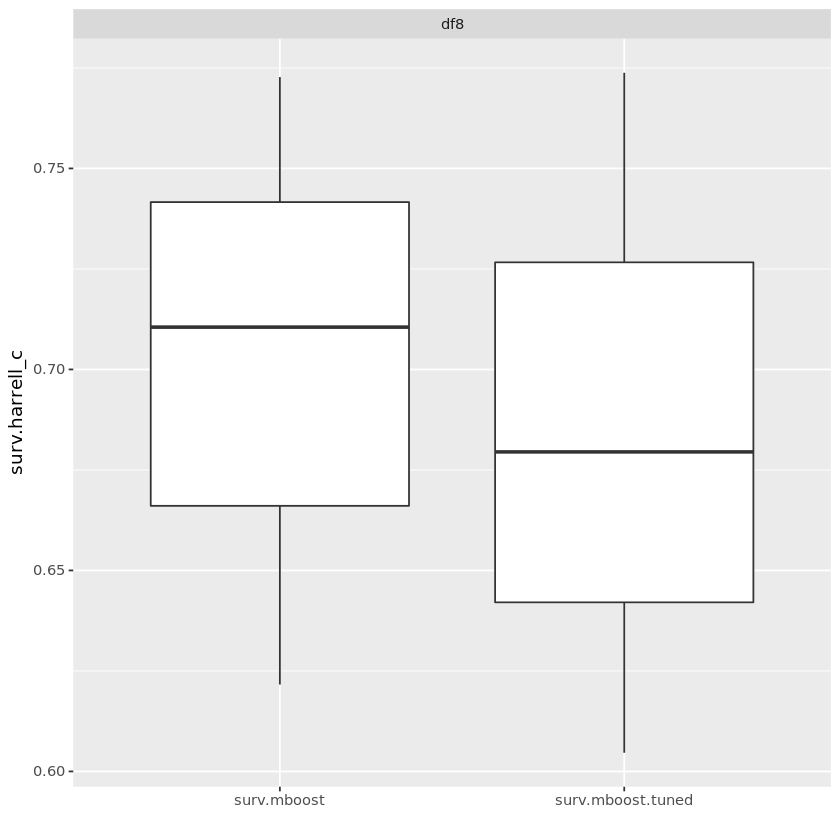

In [18]:
# autoplot the two boxplots
autoplot(c(aft_bmr, aft_bmr_2))

#### Step 2: mboost
Step 2_1: Try with a default setting

In [19]:
design <- benchmark_grid(
  tasks = tsks_train_d8,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [02:07:22.588] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:07:22.597] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 2/3) 
INFO  [02:07:22.890] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 3/3) 
INFO  [02:07:23.089] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 1/3) 
INFO  [02:07:23.259] [mlr3]  Finished benchmark 


In [20]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.738

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5618e1621a88>,df8,surv.mboost,cv,3,0.7375741


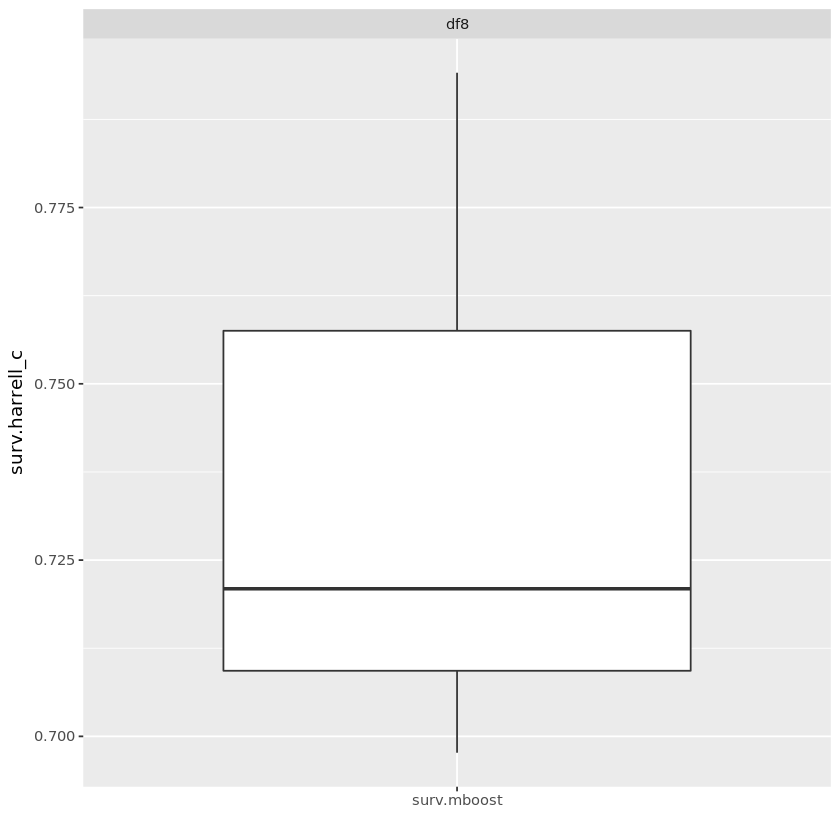

In [21]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [22]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_train_d8, grid_auto_mb, outer_rsmp, store_models = TRUE)

INFO  [02:10:03.660] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df8' (iter 2/3) 
INFO  [02:10:03.697] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [02:10:03.702] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:10:03.729] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:10:03.739] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 2/3) 
INFO  [02:10:03.871] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 1/3) 
INFO  [02:10:04.022] [mlr3]  Applying learner 'surv.mboost' on task 'df8' (iter 3/3) 
INFO  [02:10:04.149] [mlr3]  Finished benchmark 
INFO  [02:10:04.195] [bbotk] Result of batch 1: 
INFO  [02:10:04.198] [bbotk]  baselearner family mstop   nu surv.harrell_c 
INFO  [02:10:04.198] [bbotk]         bols  coxph    50 0.45      0.7777778 
INFO  [02:10:04.198] [bbotk]                                 uhash 
INFO  [02:10:04.198] [bbotk]  367a87fe-5d29-4b8b-b9a8-c60d0f240e85 
INF

In [23]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.734

surv.harrell_c 
     0.7342122

In [25]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "cindex"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 133

[[1]]$nu
[1] 0.2

Step 2_3: Autoplot the pre and after tuning boxplots

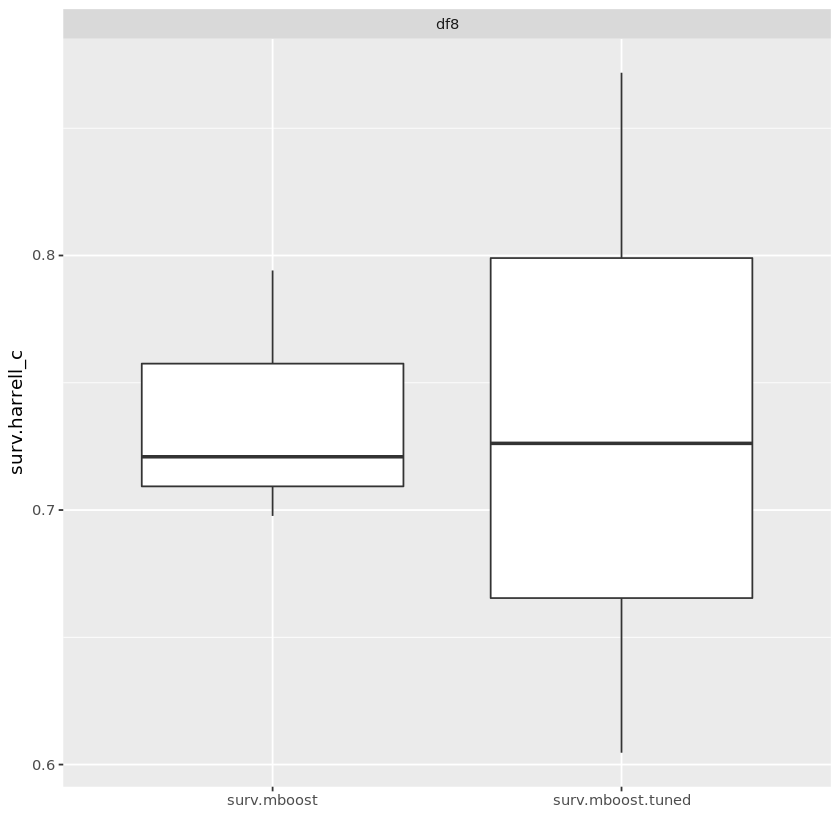

In [26]:
# autoplot the two boxplots
autoplot(c(mb_bmr, mb_bmr_2))

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [27]:
# check task
tsks_train_d8

<TaskSurv:df8> (30 x 4)
* Target: time, status
* Properties: -
* Features (2):
  - int (2): V1, V2

Step 3_2: Try with a default setting

In [28]:
library("pracma")


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [29]:
install_learners('surv.coxboost')

In [30]:
design <- benchmark_grid(
  tasks = tsks_train_d8,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
cb_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

cb_results <- cb_bmr$aggregate(measures = all_measures)
cb_results # 0.738

INFO  [02:14:42.401] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:14:42.424] [mlr3]  Applying learner 'surv.coxboost' on task 'df8' (iter 2/3) 
INFO  [02:14:42.711] [mlr3]  Applying learner 'surv.coxboost' on task 'df8' (iter 3/3) 
INFO  [02:14:42.961] [mlr3]  Applying learner 'surv.coxboost' on task 'df8' (iter 1/3) 
INFO  [02:14:43.183] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5618e1fdda78>,df8,surv.coxboost,cv,3,0.7375741


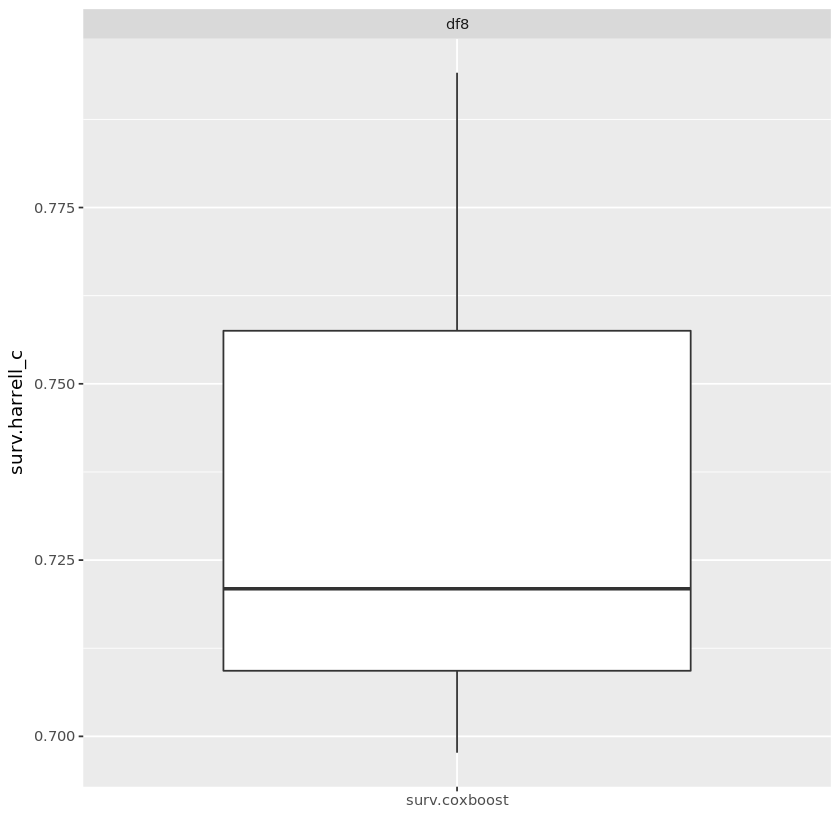

In [31]:
# plot the corresponding the performance
autoplot(cb_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [32]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 300),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling =  inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)

cb_bmr_2 = resample(tsks_train_d8, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [02:15:36.093] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df8' (iter 2/3) 
INFO  [02:15:36.128] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [02:15:36.133] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:15:36.161] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:15:36.170] [mlr3]  Applying learner 'surv.coxboost' on task 'df8' (iter 3/3) 
INFO  [02:15:36.377] [mlr3]  Applying learner 'surv.coxboost' on task 'df8' (iter 1/3) 
INFO  [02:15:36.666] [mlr3]  Applying learner 'surv.coxboost' on task 'df8' (iter 2/3) 
INFO  [02:15:36.907] [mlr3]  Finished benchmark 
INFO  [02:15:36.961] [bbotk] Result of batch 1: 
INFO  [02:15:36.964] [bbotk]  stepno  penalty stepsize.factor surv.harrell_c 
INFO  [02:15:36.964] [bbotk]      77 277.7778             0.1      0.6765873 
INFO  [02:15:36.964] [bbotk]                                 uhash 
INFO  [02:15:36.964] [bbotk]  0f25b6cb-3ce0-4b2f-98ed-fc96f

In [33]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.765

surv.harrell_c 
     0.7654045

In [34]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 217

[[1]]$penalty
[1] 233.3333

[[1]]$stepsize.factor
[1] 6.7

Step_3_4: Autoplot the pre and after tuning boxplots

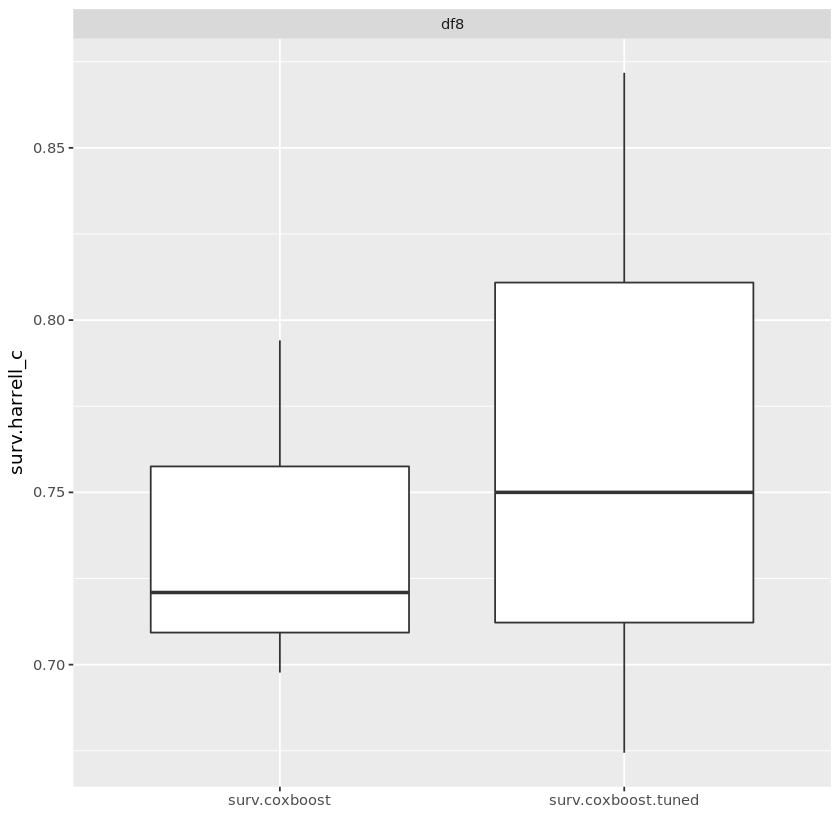

In [35]:
# autoplot the two boxplots
autoplot(c(cb_bmr, cb_bmr_2))